# Example: Biclass DTA on a 7-link toy network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kunhtkun/macposts/blob/main/examples/mcdta-7link.ipynb)

This notework contains a small example of running bi-class dynamic newtork assignment on a 7-link toy network with hybrid routing.

In [1]:
import sys
pkgs = ["matplotlib", "networkx"]
if "google.colab" in sys.modules:
    import subprocess
    # TODO: We should really use a registry and let pip do its work.
    from pip._vendor.packaging import tags
    relver = "0.2.0"
    platform = "manylinux_2_17_x86_64.manylinux2014_x86_64"
    tag = next(tags.cpython_tags(python_version=sys.version_info,
                                 platforms=[platform]))
    tpl = ("https://github.com/kunhtkun/macposts/releases/download/"
           "v{relver}/macposts-{relver}-{tag}.whl")
    subprocess.check_call([sys.executable, "-m", "pip", "install",
                           tpl.format(relver=relver, tag=tag)])
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])
else:
    import importlib.util
    pkgs = [pkg for pkg in ["macposts", *pkgs]
            if importlib.util.find_spec(pkg) is None]
    if pkgs:
        print("You need to first install: {}".format(" ".join(pkgs)))

In [2]:
import tempfile
import macposts
import networkx as nx
from matplotlib import pyplot as plt
from pathlib import Path

## Configuration

Below is the main configuration file for macposts.

In [3]:
config = """\
[DTA]
network_name = Snap_graph
unit_time = 5
total_interval = -1
assign_frq = 180
start_assign_interval = 0
max_interval = 10
flow_scalar = 10
num_of_link = 7
num_of_node = 6
num_of_O = 1
num_of_D = 1
OD_pair = 1
adaptive_ratio_car = 0.0
adaptive_ratio_truck = 0.0
routing_type = Biclass_Hybrid

[STAT]
rec_mode = LRn
rec_mode_para = 12
rec_folder = record
rec_volume = 1
volume_load_automatic_rec = 0
volume_record_automatic_rec = 0
rec_tt = 1
tt_load_automatic_rec = 0
tt_record_automatic_rec = 0

[HYBRID]
route_frq = 180

[FIXED]
path_file_name = path_table
num_path = 3
choice_portion = Buffer
buffer_length = 10
route_frq = 180

[ADAPTIVE]
route_frq = 180
"""

## Graph

The graph is a simple 7-link graph.

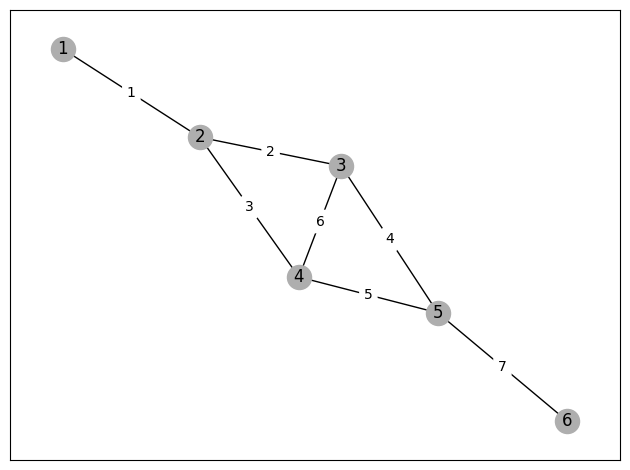

In [4]:
g = nx.Graph()
edges = {(1, 2): 1,
         (2, 3): 2,
         (2, 4): 3,
         (3, 5): 4,
         (4, 5): 5,
         (3, 4): 6,
         (5, 6): 7}
g.add_edges_from(edges.keys())
fig, ax = plt.subplots()
pos = nx.spring_layout(g, seed=17)
nx.draw_networkx(g, pos=pos, ax=ax, node_color="#aeaeae")
nx.draw_networkx_edge_labels(g, pos, edge_labels=edges, rotate=False)
fig.tight_layout()

In [5]:
graph = "#e f t\n" # Currently the reader requires a header line
graph += "\n".join(["{} {} {}".format(eid, nf, nt)
                    for (nf, nt), eid in edges.items()])
print(graph)

#e f t
1 1 2
2 2 3
3 2 4
4 3 5
5 4 5
6 3 4
7 5 6


## Input data

First come the links and nodes.

In [6]:
links = """\
#ID Type LEN(mile) FFS_car(mile/h) Cap_car(v/hour) RHOJ_car(v/miles) Lane FFS_truck(mile/h) Cap_truck(v/hour) RHOJ_truck(v/miles) Convert_factor(1)
1 PQ 1 99999 99999 99999 1 99999 99999 99999 2.1
2 CTM 1.55 35 600 40 2 25 200 20 2.1
3 CTM 1.55 35 600 40 2 25 200 20 2.1
4 CTM 1.55 35 600 40 1 25 200 20 2.1
5 CTM 1.55 35 600 40 1 25 200 20 2.1
6 CTM 1.55 35 600 40 1 25 200 20 2.1
7 PQ 1 99999 99999 99999 1 99999 99999 99999 2.1
"""

nodes = """\
#ID Type Convert_factor(only for Inout node)
1 DMOND 2.1
2 FWJ 2.1
3 FWJ 2.1
4 FWJ 2.1
5 FWJ 2.1
6 DMDND 2.1
"""

OD pairs and demands follow.

In [7]:
od_pairs = """\
#Origin_ID <-> node_ID
1 1
#Dest_ID <-> node_ID
1 6
"""

demand = """\
#Origin_ID Destination_ID <car demand by interval> <truck demand by interval>
1 1 100 100 300 100 200 100 200 100 100 100 10 9 30 7 12 7 8 10 9 11
"""

Because we are using fixed routing (as part of the hybrid routing), we also need to pre-compute a path table and a buffer for the path table.

In [8]:
path_table = """\
1 2 3 5 6
1 2 4 5 6
1 2 3 4 5 6
"""

path_table_buffer = """\
30 30 30 30 30 10 11 10 10 33 30 30 30 30 30 10 10 10 10 33
40 40 40 40 40 10 11 10 10 33 40 40 40 40 40 10 10 10 10 33
40 40 40 40 40 80 810 80 80 34 40 40 40 40 40 820 80 80 80 333
"""

## Run DTA

macposts currently only supports reading data from files, so we need to dump all the configuration and data into a directory somewhere, and run `Mcdta.initialize` on the directory to load them.

In [9]:
mcdta = macposts.Mcdta()
with tempfile.TemporaryDirectory() as d:
    d = Path(d)
    for name, contents in [("config.conf", config),
                           ("Snap_graph", graph),
                           ("path_table", path_table),
                           ("path_table_buffer", path_table_buffer),
                           ("MNM_input_demand", demand),
                           ("MNM_input_link", links),
                           ("MNM_input_node", nodes),
                           ("MNM_input_od", od_pairs)]:
        with (d / name).open("w") as f:
            f.write(contents)
    mcdta.initialize(str(d))

Loading Path Table!
Number of path 3
Finish Loading Path Table!
Checking......Graph consistent!
Passed!
Checking......Node consistent!
Passed!
Checking......Link consistent!
Passed!
Checking......OD consistent!
Passed!
Checking......OD connectivity!
Passed!
MNM_Routing_Biclass_Hybrid start load ID path mapping
MNM_Routing_Biclass_Hybrid mapping size 3


To save memory, macposts by default does not keep any data. We need to tell it which links are of interest with `Mcdta.register_links`. After that, we can use `Mcdta.run_whole` to run the DTA.

In [10]:
links = list(range(1, 8))
mcdta.register_links(links)
_ = mcdta.run_whole()

Now let us examine the results:

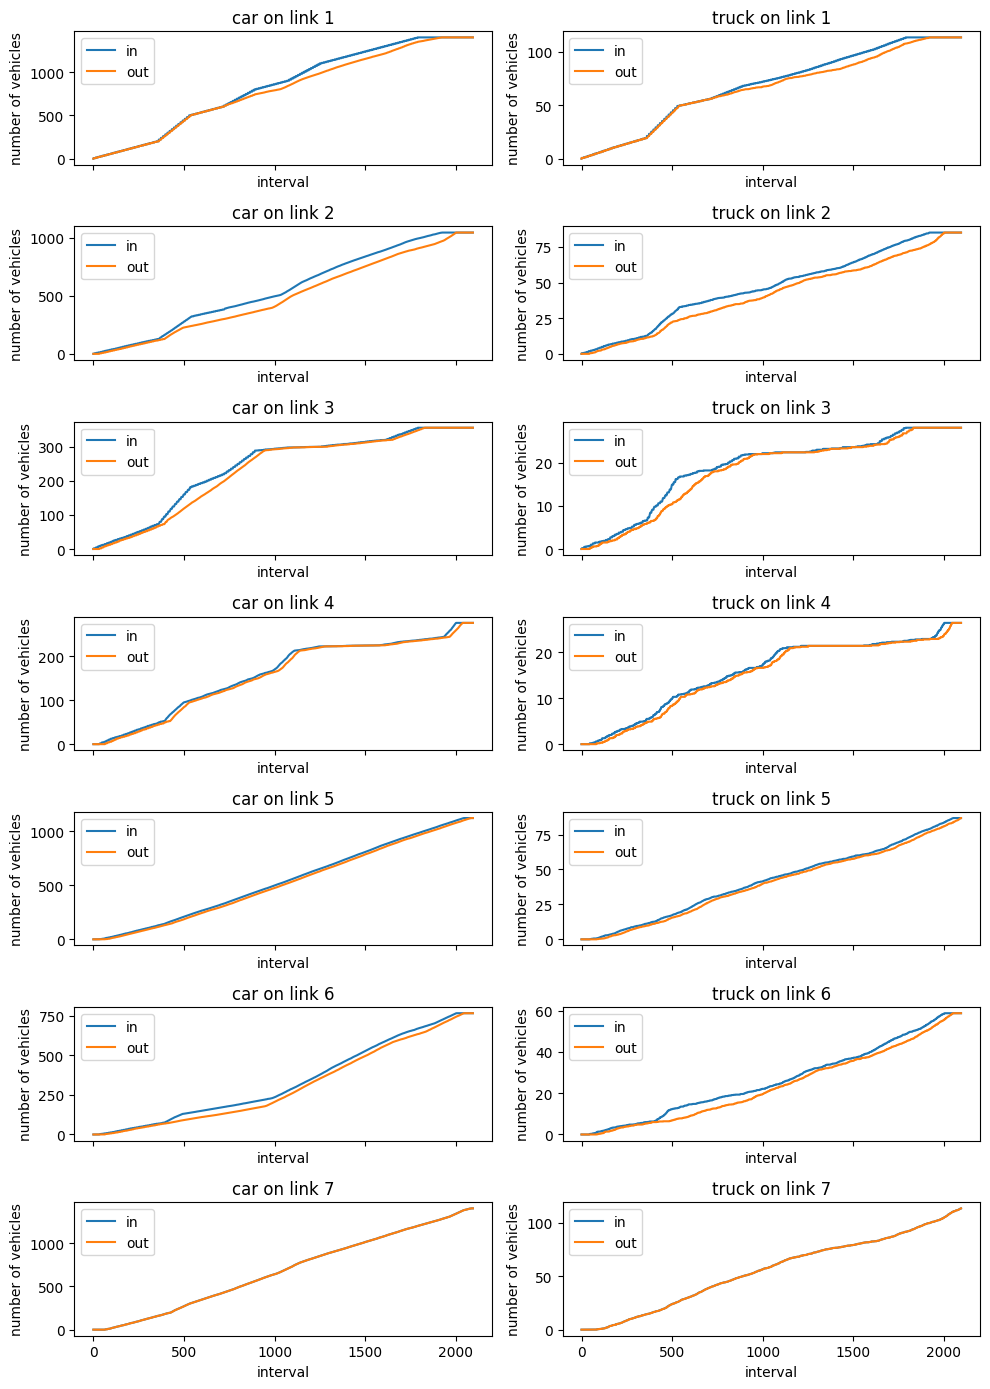

In [11]:
fig, axs = plt.subplots(len(links), 2,
                        figsize=(10, 2 * len(links)),
                        sharex=True)
for link, row in zip(links, axs):
    ccs = [("car",
            mcdta.get_car_link_in_cc(link),
            mcdta.get_car_link_out_cc(link)),
           ("truck",
            mcdta.get_truck_link_in_cc(link),
            mcdta.get_truck_link_out_cc(link))]
    for ax, (title, cc_in, cc_out) in zip(row, ccs):
        ax.plot(cc_in[:, 0], cc_in[:, 1], label="in")
        ax.plot(cc_out[:, 0], cc_out[:, 1], label="out")
        ax.set_title("{} on link {}".format(title, link))
        ax.set_xlabel("interval")
        ax.set_ylabel("number of vehicles")
        ax.legend()
fig.tight_layout()